In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY,date2num,num2date,AutoDateLocator
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc,candlestick2_ochl,volume_overlay3

from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from featureapp import libs as ftlibs
from featureapp import models as ftmd
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import featureapp.models as ftmd
import featureapp.tasks as fttks
import queryapp.models as qrymd
import queryapp.tasks as qrytks

import charts.chartservers.libs as chservlibs
import charts.libs as chlibs

from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs


import featureapp as ftapp
import utility as uty
from utility import models as utymd
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
from talib.abstract import *
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
from utility import maintenance as mnt
import os 
import json
from django.contrib.auth.models import AnonymousUser
import threading

stk=stkmd.Stockmeta.objects.get(Symbol='TSLA')
Fromdate=pd.datetime(2008,1,1)
Todate=pd.datetime.today()
Trange=pd.date_range(Fromdate,Todate)
Trange=[T.date() for T in Trange if T.weekday()<=4]

import json
# fttks.computefeatuers(stk.id,Trange)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This 

# Charting

In [ ]:
entries=[
    {'Symbol':'TSLA','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  },
    {'Symbol':'AAPL','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  }
]
chservlibs.request_db_charts(entries,5003)
# img=chlibs.CurrentByFutureChart_bydb(entries[0]['T0'],entries[0]['TF'],entries[0]['Symbol'],indicatorlist=(),pricecols=(),querycols=(),featcols=())


# Running Features

In [27]:

import featureapp.models as ftmd
import featureapp.featuremodel as dtaftmd
import featureapp.FeatureCodes.AnonymousUser as FCan

import dataapp.datamanager as dtamng
import stockapp.models as stkmd
import pandas as pd
symbolid=stkmd.Stockmeta.objects.get(Symbol='AAPL').id
Fromdate=pd.datetime(2010,1,1).date()
Todate=pd.datetime(2017,1,1).date()

FM=FCan.features(symbolid,Fromdate,Todate)
FM.filename
FM.Initialize()
FM.ComputeAllFeatures()
FM.saveall_overwrite()
# FM.DM=DataManager(SymbolIds=[Symbolid])
# FM.Trange=filter(lambda x: x>=self.Fromdate and x<=self.Todate,self.DM.TradingDates)
# FM.DM.AddStockData()

# get the feature compute code
# FM.FC=ftmd.FeatureComputeCode.objects.get(Username=self.filename)

# load the features from db
# FM.DM.Addfeaturecols()


TIMING : GetStockData time = 0.115822 on 2017-10-15 06:55:11 with args: ((),{'Symbolids': [1165]}) 
TIMING : GetFeatures time = 0.130154 on 2017-10-15 06:55:11 with args: ((),{'Symbolids': [1165]}) 
TIMING : addindicators time = 0.000890999999999 on 2017-10-15 06:55:11 with args: ((             Close    Open    High     Low     Volume Symbol  Symbol_id  \
T                       ,{}) 
Done compute
Done save


In [28]:
ftmd.FeaturesData.objects.all().delete()

(19814691, {u'featureapp.FeaturesData': 19814691})

In [32]:
import datascience.models as dtscmd 
dtscmd.ComputeFunc.objects.all().delete()
dtscmd.Project.objects.all().delete()

(0, {})

In [ ]:

import featureapp.models as ftmd
import featureapp.featuremodel as dtaftmd
import featureapp.FeatureCodes.AnonymousUser as FCan

import dataapp.datamanager as dtamng
import stockapp.models as stkmd
import pandas as pd
symbolid=stkmd.Stockmeta.objects.get(Symbol='AAPL').id
Fromdate=pd.datetime(2010,1,1).date()
Todate=pd.datetime(2017,1,1).date()

DM.dtamng.DataManager(SymbolIds=[symbolid])

# Running Queries

In [ ]:
querycodes=qrymd.QueryComputeCode.objects.all()
computecode=querycodes[0]
computeclass=computecode.importcomputeclass()
CQ=computeclass(stk.id,Trange)
CQ.computeall(skipdone=True)
CQ.saveall()

In [ ]:
CQ.OutcomeCharts()

In [ ]:
CQ.getquerylist()

In [ ]:
CQ.chartfeatures(addpricecols=(),ip=5562,
addfeatcols=[
    ['CCI5','CCI50'],
    ['PastPROFIT10days','PastLOSS10days'],['FutPROFIT10days','FutLOSS10days']
],
addquerycols=[
    'CCICHERRIES',
]
)

# Registering function

In [ ]:
from datascience import libs as dtsclibs
import pandas as pd

@dtsclibs.register_compfunc(RequiredImports=['import pandas as pd','from dataapp import libs as dtalibs'],overwrite_if_exists=False)
def extractdataset(data_id,Symbol):
    """
    @funcName : test
    @input x : an int
    @output df : pd.DataFrame, some random 2 by 2 
    @description : takes an int and then returns a dummy dataframe. This is just for testing purposes
    @Source : 
    def extractdataset(data_id,Symbol):
        window=60
        window_fut=30
        Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
                pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )

        N=len(Tfs)
        dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
        X,X_Meta=dtalibs.Getbatchdata(dfinstants)

        dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
        Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)

        shard=dtscmd.DataShard(Data__id=data_id)
        shard.Info['X_Meta']=X_Meta
        shard.Info['Y_Meta']=Y_Meta
        shard.save()

        np.savez_compressed(shard.shardpath(),X=X,Y=Y)
    """
    
    window=60
    window_fut=30
    Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
            pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )
    
    N=len(Tfs)
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
    X,X_Meta=dtalibs.Getbatchdata(dfinstants)
    
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
    Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)
    
    shard=dtscmd.DataShard(Data__id=data_id)
    shard.Info['X_Meta']=X_Meta
    shard.Info['Y_Meta']=Y_Meta
    shard.save()
    
    np.savez_compressed(shard.shardpath(),X=X,Y=Y)

extractdataset.id


# Creating initial Stock price dataset

In [1]:
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
projid,dataid=dtsclibs.register_dataset(project_Name="PredictReturn",project_Info={'description': "Data taken on every Monday. 360 days back and 60 days forward"},
                                        Datatype='RawProcessed',GroupName="AllStocks",tag="1",
                                        data_format='npz',Modeltype='Regression',
                                        TransformedFromDataId=None,TransFuncId=None, use_project_ifexists=True)

dtsctks.CreateStockData_2(360,60,dataid,None)

In [ ]:
print dtscmd.Data.objects.filter(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')
data = dtscmd.Data.objects.get(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')

data.datapath()

In [ ]:
dtscmd.DataShard.objects.filter(Data=data).delete()

In [ ]:
dtscmd.DataShard.objects.all()

# Create transformed dataset

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

func=stktrfrmr.StandardizeData_HLmeanVolumeSMA01_X30_Y5return_interpcleaned_flatout
funcid=func.id
DataInfo={'description':func.__doc__}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol',DataInfo=DataInfo,tag='NormalizedDerivedX23_Y5_HLSMAVolSMA_FromId6',TransformedFromDataId=6,TransFuncId=funcid ,DeleteShards=True )

dtsctks.Perform_TransformData(dataid)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  DataShardMeta_1
function id =  29
over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned
function id =  27
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout
function id =  28
over writing previous function
saving function :  StandardizeData_HLmeanVolumeSMA01_X30_Y5return_interpcleaned_flatout
function id =  30
Project  PredictReturn  already exists
The dataset already exists
updating data info
Deleting the existing shards for this

In [17]:
dtscmd.DataShard.objects.filter(Data__id=58).count()

87

In [12]:
X.shape

(301, 184)

8.0

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcid=stktrfrmr.StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout.id
DataInfo={'description':'FLATTENED!!!  All stocks data, close price is made into 0-1, Volume is made into 0-1, Y is profit/(profit+loss) for next 5 days'}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol_FLATTENED',DataInfo=DataInfo,tag='NormalizedDerived30days_5daysFromId6',TransformedFromDataId=6,TransFuncId=funcid,DeleteShards=True )

dtsctks.Perform_TransformData(dataid)



Project  PredictReturn  already exists
The dataset already exists
updating data info
Deleting the existing shards for this data
saving transfoermer function to this dataset
('project id', 'data id')  :  (7, 42)


In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl

data=dtscmd.Data.objects.get(id=43)
X,Y,Meta=data.getdata()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X.shape

(1546208, 60)

# Get Shard Meta

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcId=stktrfrmr.DataShardMeta_1.id
dataId=42
M=dtsctks.applyfunc2data(funcId,dataId,wait=True)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  DataShardMeta_1
function id =  29
over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned
function id =  27
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout
function id =  28


In [ ]:
M.values()[:10]

In [4]:
reduce(lambda x,y:[x[0]+y[0],x[1]+y[1],x[2]+y[2][0],x[3]+y[3][0]],M.values(),[0,0,0,0]) 

[0, 0, 2315765, 2315765]

# Get Overview of Projects and data

In [4]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.stockdata_transformers as stktrfrmr


    
print "------------ Data ----------------------"
for proj in dtscmd.Project.objects.all():
    print "Project  :: ","ProjectName=",proj.Name," ProjectId",proj.id
    for data in dtscmd.Data.objects.filter(Project=proj).order_by("id"): #
        print "\t","id=",data.id," ParentId=",data.ParentData.id if data.ParentData is not None else None 
        print "\t","GroupName=",data.GroupName," tag=",data.tag
        print "\t","Modeltype=",data.Modeltype," DataStructure=",data.DataStructure
        print "\t","Datatype=",data.Datatype," Dataformat=",data.Dataformat
        print "\t","#shards=",dtscmd.DataShard.objects.filter(Data=data).count()
        print "\t ------------------"
        

over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5
function id =  25
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5_flatout
function id =  26
------------ Data ----------------------
Project  ::  ProjectName= PredictReturn  ProjectId 7
	id= 6  ParentId= None
	GroupName= AllStocks  tag= 1
	Modeltype= Regression  DataStructure= Channels
	Datatype= RawProcessed  Dataformat= npz
	#shards= 6548
	 ------------------
	id= 42  ParentId= 6
	GroupName= AllStocksCloseVol_FLATTENED  tag= NormalizedDerived30days_5daysFromId6
	Modeltype=

# Create Train and Valid

In [45]:
import datascience.ML.MLlibs as MLlibs
MLlibs.get_train_test_from_RawProcessed(58)

Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 59)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 60)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 61)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 62)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 63)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 64)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 65)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 66)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 67)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 68)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 69)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 70)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 71)

# Generate Models 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().count()

72

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.RandomForrrest_2()
M.GenModels(proj,traindata)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:

from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.SVC_1()
M.GenModels(proj,traindata)


In [4]:

from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.QDA_1()
M.GenModels(proj,traindata)




In [ ]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.NN_1()
M.GenModels(proj,traindata)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


184 2 50 100 0.02 0 sigmoid 368
compile =  0.0696158409119
save =  0.0511529445648
2
184 2 50 100 0.02 0 sigmoid 93
compile =  0.170254230499
save =  0.031613111496
3
184 2 50 100 0.02 0 relu 368
compile =  0.0393362045288
save =  0.0142769813538
4
184 2 50 100 0.02 0 relu 93
compile =  0.0411579608917
save =  0.0160109996796
5
184 2 50 100 0.02 0.2 sigmoid 368
compile =  0.0467600822449
save =  0.023090839386
6
184 2 50 100 0.02 0.2 sigmoid 93
compile =  0.0429379940033
save =  0.0286300182343
7
184 2 50 100 0.02 0.2 relu 368
compile =  0.0590920448303
save =  0.0323839187622
8
184 2 50 100 0.02 0.2 relu 93
compile =  0.0511960983276
save =  0.0345780849457
9
184 2 50 100 0.2 0 sigmoid 368
compile =  0.0406560897827
save =  0.0309629440308
10
184 2 50 100 0.2 0 sigmoid 93
compile =  0.0365490913391
save =  0.0312111377716
11
184 2 50 100 0.2 0 relu 368
compile =  0.0373060703278
save =  0.0314371585846
12
184 2 50 100 0.2 0 relu 93
compile =  0.036966085434
save =  0.0317130088806
13


save =  0.329963922501
100
184 2 100 500 0.02 0 relu 93
compile =  0.0404269695282
save =  0.334634065628
101
184 2 100 500 0.02 0.2 sigmoid 368
compile =  0.0466890335083
save =  0.338186979294
102
184 2 100 500 0.02 0.2 sigmoid 93
compile =  0.0461449623108
save =  0.334941864014
103
184 2 100 500 0.02 0.2 relu 368
compile =  0.0430729389191
save =  0.306221008301
104
184 2 100 500 0.02 0.2 relu 93
compile =  0.0466709136963
save =  0.328294038773
105
184 2 100 500 0.2 0 sigmoid 368
compile =  0.0418920516968
save =  0.33665895462
106
184 2 100 500 0.2 0 sigmoid 93
compile =  0.0389869213104
save =  0.333751916885
107
184 2 100 500 0.2 0 relu 368
compile =  0.0441961288452
save =  0.343854904175
108
184 2 100 500 0.2 0 relu 93
compile =  0.0364170074463
save =  0.356847047806
109
184 2 100 500 0.2 0.2 sigmoid 368
compile =  0.0475640296936
save =  0.364627122879
110
184 2 100 500 0.2 0.2 sigmoid 93
compile =  0.04833984375
save =  0.330704927444
111
184 2 100 500 0.2 0.2 relu 368
com

In [1]:
from __future__ import division
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().count()
# NN_1

244

In [ ]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

model=dtscmd.MLmodels.objects.get(id=4)
M=MLmod.RandomForrrest_1()
M.loadmodel(model)
M.loaddata()
X,Y=M.pre_processing_train()
M.train()
M.Run_validation_all()

In [1]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()


(490, {u'datascience.MLmodels': 490, u'datascience.ModelMetrics': 0})

In [6]:
from datascience import models as dtscmd
modelnames=dtscmd.MLmodels.objects.filter(Data__id=59).values_list('Name',flat=True).distinct()
for name in modelnames:
    print "-------------- "+name+" -------------- "
    print 'All       : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name).count()
    print 'Untrained : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name,Status='UnTrained').count()
    print 'Trained   : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name,Status='Trained').count()

# print model.created_at
# print model.updated_at
# model.id

-------------- NN_1 -------------- 
All       :  192
Untrained :  180
Trained   :  11


In [1]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()

(244, {u'datascience.MLmodels': 244, u'datascience.ModelMetrics': 0})

In [5]:
from __future__ import division
from datascience import models as dtscmd

SS=dtscmd.ModelCode.objects.all()[0]
SS.Username='AnonymousUser'
SS.save()

# print dtscmd.ModelCode.objects.all()[0].Code

In [ ]:
from __future__ import division
from datascience import models as dtscmd

modelid=2642
model=dtscmd.MLmodels.objects.get(id=modelid)
model.Status='UnTrained'
model.save()
MCode=dtscmd.ModelCode.objects.get(Username=model.Userfilename)
Mclass=MCode.importobject(model.Name)
M=Mclass()
M.loadmodel(model)
M.loaddata()
M.train()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
datascience/ML/MLmodels.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.clf.fit(X,Y)


In [10]:
import os
os.path.isdir('/home/venkat/GoogleDrive/repos/trade_analytics/trade_analytics/bigdata/datascience/Projects/PredictReturn/Models')

True

In [6]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

dtsctks.TrainProject(7)


In [4]:
list(dtscmd.ModelMetrics.objects.all().values_list('Metrics',flat=True))

[{u'acc': 0.5873301132989499,
  u'avgprec': 0.7500245475466635,
  u'logloss': 14.253347959156393,
  u'precisionscore': 0.5873301132989499,
  u'recallscore': 0.5873301132989499},
 {u'acc': 0.5778389385061795,
  u'avgprec': 0.7391744823896076,
  u'logloss': 14.58117097308135,
  u'precisionscore': 0.5778389385061795,
  u'recallscore': 0.5778389385061795},
 {u'acc': 0.5755662023735734,
  u'avgprec': 0.7360772170628063,
  u'logloss': 14.659673633086008,
  u'precisionscore': 0.5755662023735734,
  u'recallscore': 0.5755662023735734},
 {u'acc': 0.5804014517443152,
  u'avgprec': 0.7419373765432435,
  u'logloss': 14.492664477413697,
  u'precisionscore': 0.5804014517443152,
  u'recallscore': 0.5804014517443152},
 {u'acc': 0.5781638007321095,
  u'avgprec': 0.7417555815507899,
  u'logloss': 14.569947829098775,
  u'precisionscore': 0.5781638007321095,
  u'recallscore': 0.5781638007321095},
 {u'acc': 0.5707517441852911,
  u'avgprec': 0.7286107886195881,
  u'logloss': 14.825961350411745,
  u'precision

In [10]:
np.round(Y)

array([[ 1.],
       [ 1.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])

In [5]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
X,YY,Meta=traindata.getdata()

In [7]:
Y=YY.copy()
Y[Y<5]=0
Y[Y>=5]=1

In [23]:
Y

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [24]:
X[(Y==1).reshape(1,-1)[0],:]

array([[ 0.71067795,  0.71067795,  0.72538924, ...,  0.39808993,
         0.47631846,  0.51671738],
       [ 0.19613575,  0.18811493,  0.37081135, ...,  0.38218681,
         0.35160145,  0.36272483],
       [ 0.75250164,  0.75250164,  0.68242133, ...,  0.42132235,
         0.43131029,  0.43402331],
       ..., 
       [ 0.35034309,  0.37933701,  0.36242389, ...,  0.31574803,
         0.32472441,  0.35212598],
       [ 0.63918621,  0.50406134,  0.36362256, ...,  0.54581288,
         0.51055252,  0.53806791],
       [ 0.57985668,  0.65347993,  0.66624129, ...,  0.4548038 ,
         0.40539037,  0.3950445 ]])

In [8]:
X0=X[(Y==0).reshape(1,-1)[0],:]
X1=X[(Y==1).reshape(1,-1)[0],:]

In [9]:
print X0.shape
print X1.shape

(1238585, 184)
(158724, 184)


In [11]:
i=0
j=0
while i<1000:
    fig,ax=plt.subplots(2,2,figsize=(15,10))
#     XX=X0[i,:].reshape(23,8,order='F')
#     ax[0].plot(XX[:,0:3])
#     ax[0].plot(XX[:,3],linestyle='-.')
#     ax[0].plot(XX[:,4:6],linestyle='--')
    XX=X1[i,:].reshape(23,8,order='F')
    ax[0][0].plot(XX[:,0:3])
    ax[0][0].plot(XX[:,3],linestyle='-.')
    ax[0][0].plot(XX[:,4:6],linestyle='--')

    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[0][1].plot(XX[:,0:3])
    ax[0][1].plot(XX[:,3],linestyle='-.')
    ax[0][1].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[1][0].plot(XX[:,0:3])
    ax[1][0].plot(XX[:,3],linestyle='-.')
    ax[1][0].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[1][1].plot(XX[:,0:3])
    ax[1][1].plot(XX[:,3],linestyle='-.')
    ax[1][1].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    

    plt.savefig('plot_'+str(j),bbox_inches='tight')
    plt.close()
    j=j+1

In [13]:
ss=''
for k in range(j):
    ss=ss+'<img src="plot_'+str(k)+'.png">'
with open('Goodchart.html','w') as F:
    F.write(ss)
    

In [38]:
import dataapp.datamanager as dtamng
import dataapp.libs as dtalibs
import stockapp.models as stkmd
import featureapp.models as ftamd

stk1=stkmd.Stockmeta.objects.get(Symbol='AAPL')
stk2=stkmd.Stockmeta.objects.get(Symbol='TSLA')

DM=dtamng.DataManager(SymbolIds=[stk1.id,stk2.id],Append2ReqCols=['Sector','Industry','CCI5','CCI50','CCI100','VolSMA10','VolSMA20'])

# print DM.FeatureCols
# print DM.StockMetaCols
# print DM.DataCols

DM.RequiredCols

DM.AddStockData()
DM.AddStockMetacols()
print "-----------------------"
print DM.DF[1165].index
DM.Addfeaturecols()
print DM.DF[1165].index
DM.AddIndicatorCols()

col2write=['Close',u'Open', u'High',u'Low','Volume',u'SectorId',
            u'IndustryId',             u'CCI5',
                 u'CCI50',            u'EMA8',         u'EMAstd8',
                 u'SMA10',          u'SMA100',           u'SMA20',
                u'SMA200',           u'SMA50',        u'SMAstd20',
              u'VolSMA10',u'VolSMA20']

TFs=dtalibs.getdatearrays(ondays='EveryMonday')
# for H in DM.CreateTrainingDataSet(col2write,TFs,width_back=360,width_front=180):
#     H


TIMING : GetStockData time = 0.122641 on 2017-10-16 12:16:33 with args: ((),{'Symbolids': [1165]}) 
TIMING : GetStockData time = 0.054494 on 2017-10-16 12:16:33 with args: ((),{'Symbolids': [1841]}) 
-----------------------
Index([2002-01-02, 2002-01-03, 2002-01-04, 2002-01-07, 2002-01-08, 2002-01-09,
       2002-01-10, 2002-01-11, 2002-01-14, 2002-01-15,
       ...
       2017-04-25, 2017-04-26, 2017-04-27, 2017-04-28, 2017-05-01, 2017-05-02,
       2017-05-03, 2017-05-04, 2017-05-05, 2017-05-08],
      dtype='object', name=u'Date', length=3864)
TIMING : GetFeatures time = 0.001195 on 2017-10-16 12:16:33 with args: ((),{'Symbolids': [1165]}) 
TIMING : GetFeatures time = 0.00114599999995 on 2017-10-16 12:16:33 with args: ((),{'Symbolids': [1841]}) 
Index([2002-01-02, 2002-01-03, 2002-01-04, 2002-01-07, 2002-01-08, 2002-01-09,
       2002-01-10, 2002-01-11, 2002-01-14, 2002-01-15,
       ...
       2017-04-25, 2017-04-26, 2017-04-27, 2017-04-28, 2017-05-01, 2017-05-02,
       2017-05-03

4
4


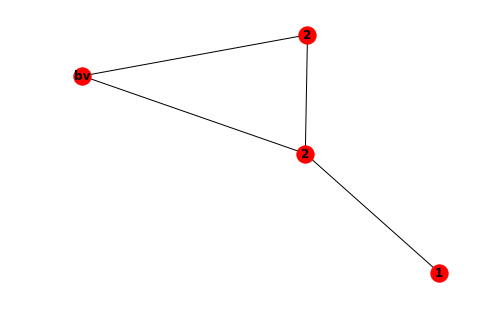

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_node('1')
G.add_nodes_from([2, 'bv'])
G.add_edge('1','2')
G.add_edge(2,'bv')
G.add_edge('2','bv')
G.add_edge('2',2)
print G.number_of_nodes()
print G.number_of_edges()

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()